<a href="https://colab.research.google.com/github/Mitmischer/solar-prediction/blob/main/notebook_3_univariate_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package installation

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
!pip install armagarch pyextremes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.9 MB/s eta 0:00:00


In [3]:
!pip install gluonts armagarch statsmodels statsforecast s3fs datasetsforecast GPy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing in

In [4]:
!pip install git+https://github.com/Nixtla/neuralforecast.git@main git+https://github.com/RJT1990/pyflux

  Cloning https://github.com/Nixtla/neuralforecast.git (to revision main) to /tmp/pip-req-build-6a82arwc
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast.git /tmp/pip-req-build-6a82arwc
  Resolved https://github.com/Nixtla/neuralforecast.git to commit 957a0ccb34d17395ad1da15ef1b027f8dc2c1944
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/RJT1990/pyflux to /tmp/pip-req-build-uq8nb4c9
  Running command git clone --filter=blob:none --quiet https://github.com/RJT1990/pyflux /tmp/pip-req-build-uq8nb4c9
  Resolved https://github.com/RJT1990/pyflux to commit 297f2afc2095acd97c12e827dd500e8ea5da0c0f
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12

In [5]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193269 sha256=5e63cfb4eb9fd4db26179aadd1beb2b275a1be0fbbb1a6abb18f10cd0f13a809
  Stored in directory: /root/.cache/pip/wheels/94/75/88/b853cf33b0053b0a001dca55b74d515048b7656e736364eb57
Successfully built pyod


# Notebook parameters (IMPORTANT!)

In [6]:
# if False, cells that take a lot of time are not run.
# For production and the actual results, use slow=True!
slow = True

# Data Preparation

In [7]:
import huggingface_hub
import pandas as pd
import numpy as np

In [8]:
splits = {'train': 'train_ts.csv', 'validation': 'val_ts.csv', 'test': 'test_ts.csv'}
df_train = pd.read_csv("hf://datasets/Creatorin/solarpower/" + splits["train"])
df_validation = pd.read_csv("hf://datasets/Creatorin/solarpower/" + splits["validation"])
df_test = pd.read_csv("hf://datasets/Creatorin/solarpower/" + splits["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
df = pd.concat([df_train, df_validation, df_test])
ts = df["Leistung"]
ts.index = pd.to_datetime(ts.index, utc=True)

In [173]:
ts.head()

,0
2015-01-01 00:00:00+00:00,-1.355870e-09
2015-01-01 01:00:00+00:00,-1.355870e-09
2015-01-01 02:00:00+00:00,-1.355870e-09
2015-01-01 03:00:00+00:00,-1.355870e-09
2015-01-01 04:00:00+00:00,-1.355870e-09


<Axes: >

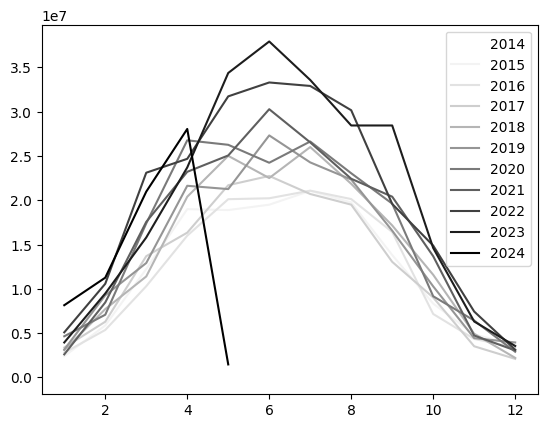

In [11]:
# see https://stackoverflow.com/questions/30379789/plot-pandas-data-frame-with-year-over-year-data
pv = pd.pivot_table(df, index=ts.index.month, columns=ts.index.year,
                    values='Leistung', aggfunc='sum')
pv.plot(cmap="Greys")

The increasing monthly trend is clearly visible.

In [12]:
# Those values need imputation!
pd.date_range(ts.index.min(), ts.index.max(), freq='15Min').difference(ts.index)

DatetimeIndex(['2014-12-31 23:15:00+00:00', '2014-12-31 23:30:00+00:00',
               '2014-12-31 23:45:00+00:00', '2015-01-01 00:15:00+00:00',
               '2015-01-01 00:30:00+00:00', '2015-01-01 00:45:00+00:00',
               '2015-01-01 01:15:00+00:00', '2015-01-01 01:30:00+00:00',
               '2015-01-01 01:45:00+00:00', '2015-01-01 02:15:00+00:00',
               ...
               '2024-05-01 17:45:00+00:00', '2024-05-01 18:15:00+00:00',
               '2024-05-01 18:30:00+00:00', '2024-05-01 18:45:00+00:00',
               '2024-05-01 19:15:00+00:00', '2024-05-01 19:30:00+00:00',
               '2024-05-01 19:45:00+00:00', '2024-05-01 20:15:00+00:00',
               '2024-05-01 20:30:00+00:00', '2024-05-01 20:45:00+00:00'],
              dtype='datetime64[ns, UTC]', length=245442, freq=None)

In [13]:
# Interpolation
ts = ts.interpolate(method="time")
# Only now can we infer a frequency.
ts = ts.asfreq(pd.infer_freq(ts.index))

In [14]:
# Normalize
avg_train, dev_train = ts.mean(), ts.std()
ts_series = (ts - avg_train)/dev_train

<Axes: >

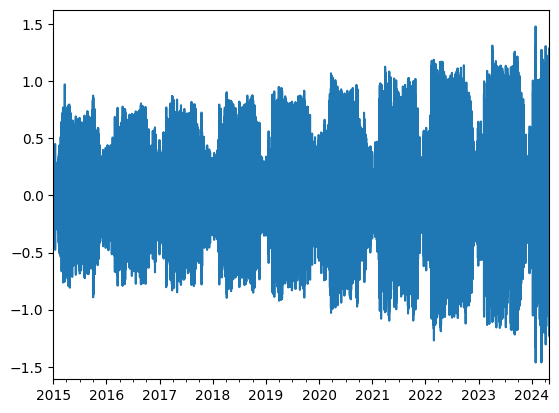

In [15]:
# Remove trend
ts_series = ts_series.diff().dropna()
ts_series.plot()

In [16]:
# remove increasing volatility
annual_volatility = ts_series.groupby(ts_series.index.year).std()
annual_vol_per_day = ts_series.index.map(lambda d: annual_volatility.loc[d.year])
ts_corrected_variance = ts_series/annual_vol_per_day
monthly_mean = ts_corrected_variance.groupby(ts_corrected_variance.index.month).mean()
monthly_mean_per_day = ts_corrected_variance.index.map(lambda d: monthly_mean.loc[d.month])
ts_corrected_variance= ts_corrected_variance - monthly_mean_per_day
ts_corrected_variance= ts_corrected_variance[~np.isnan(ts_corrected_variance)]

In [17]:
annual_volatility = ts.groupby(ts.index.year).std()
annual_vol_per_day = ts.index.map(lambda d: annual_volatility.loc[d.year])

<Axes: >

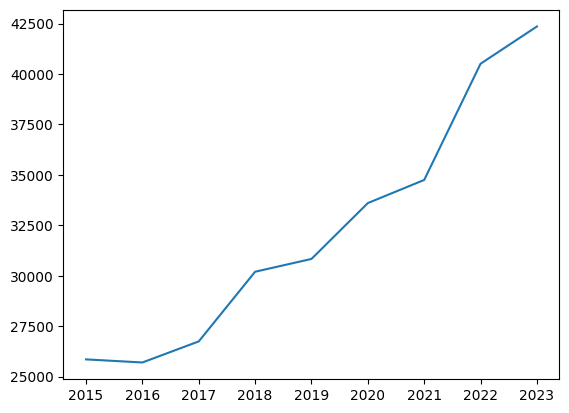

In [18]:
annual_volatility[0:10].plot()

Removing the increasing volatility will yield a perfectly stationary time series. One might argue that this is information leakage, but the annual volatility follows a linear trend and is inferrable.
The values for 2024 are removed from the plot as the year 2024 is not complete (and has a lower volatility).

<Axes: >

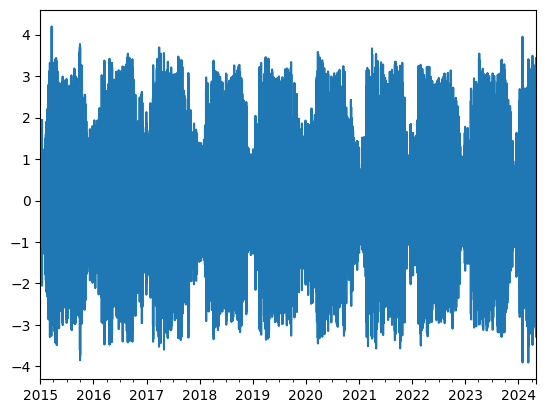

In [19]:
ts = ts_corrected_variance
ts.plot()

# Spectral Analysis

In [20]:
# spectral analysis
from scipy import signal
from scipy.signal import periodogram as periodogram_f
from scipy.fft import fftfreq, fftshift
from scipy.fft import fft, ifft, fft2, ifft2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

(0.0, 5000.0)

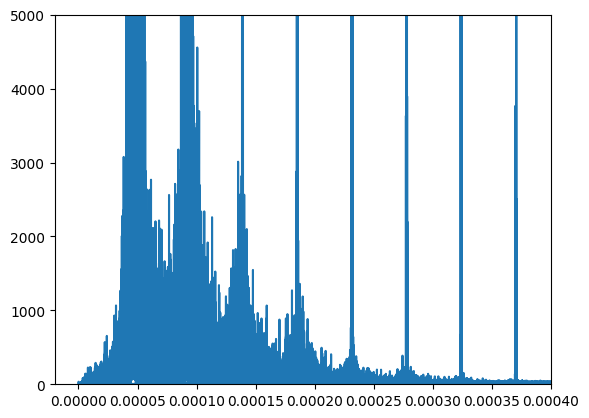

In [21]:
# looks (and should be!) similar to the "manual" calculation above.
# Note that in the manual calculation, we get a symmetric graph. That's to be expected (check out the videos).
dt = 15*60
rate = 1/dt
frequencies, periodogram = periodogram_f(np.asarray(ts), fs=rate, window="hamming")
plt.plot(fftshift(frequencies), fftshift(periodogram))
plt.xlim(-0.00002, 0.0001*4)
plt.ylim(0, 10000/2)

We see some clear peaks corresponding to strong frequencies in the signal.

(0.0, 25000.0)

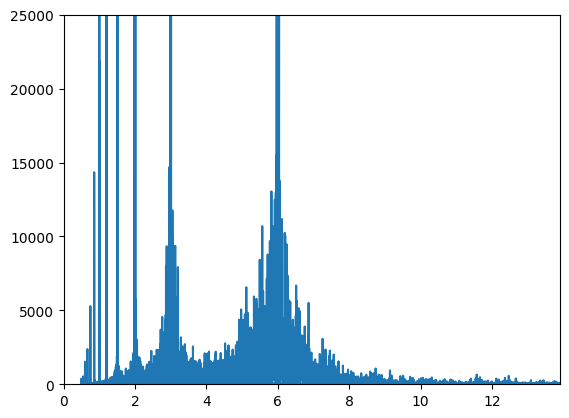

In [22]:
periodogram_as_series = pd.Series(fftshift(periodogram), index=fftshift(frequencies))
periodogram_as_series = periodogram_as_series[periodogram_as_series.index > 0]
# convert index from frequencies to periods and convert the periods to hours
# TODO: is the calculation to hours correct (note that  we already specified the sampling rate during the fft!)?
periodogram_as_series.index = (1/periodogram_as_series.index)/3600
plt.plot(periodogram_as_series)
plt.xlim(0,100000/3600/2)
plt.ylim(0, 5000*10/2)

The frequencies can be converted to time intervals.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 1.6666666666666667)

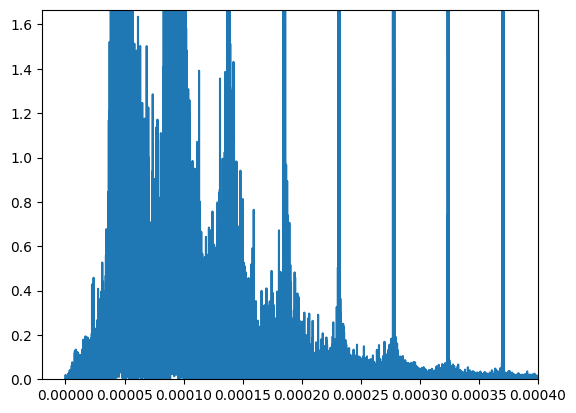

In [23]:
# yet another way to calculate the FFT, from the "denoising" video.
# That'll allow us to drop frequencies later.
n = len(ts)
fhat = np.fft.fft(ts, n)
PSD = fhat*np.conj(fhat)/n
freq = (1/(dt*n))*np.arange(n)
L= np.arange(1, np.floor(n/2), dtype="int")
plt.plot(freq[L], PSD[L])
plt.xlim(-0.00002, 0.0001*4)
plt.ylim(0, 10000/(1500*4))

[]

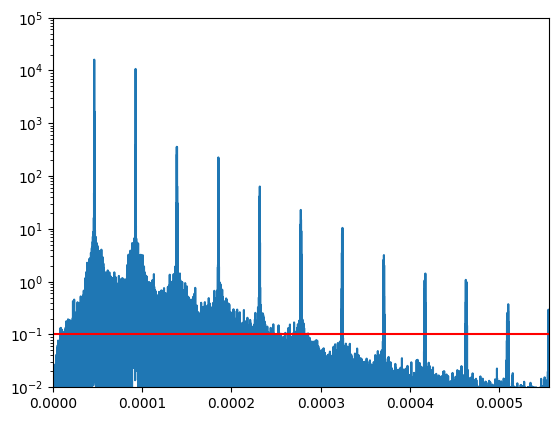

In [24]:
# Now decide on the frequencies to cut off.
plt.plot(freq, PSD)
plt.ylim(1e-2,1e5)
plt.xlim(0,max(freq)/2)
plt.axhline(y=1e-1, color="r")
plt.semilogy()

We want to keep the strong frequencies in the signal and remove the other ones (which make the signal noisy).
Visually, a cutoff of 0.1 drops a lot of less important frequencies while keeping ~80% of the major ones.

In [25]:
indices = PSD > 1e-1
# Filter and reconstruct the signal on the retained frequencies (reverse fourier transform)
PSDclean = PSD*indices
fhat = indices*fhat
ffilt = np.fft.ifft(fhat)

In [26]:
# number of surviving frequencies
np.sum(indices)

15865

[]

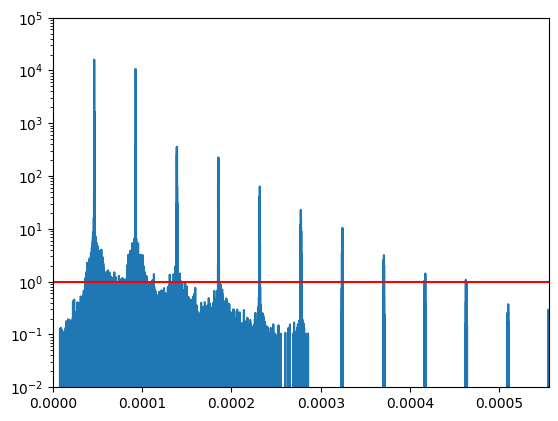

In [27]:
plt.plot(freq, PSDclean)
plt.ylim(1e-2,1e5)
plt.xlim(0,max(freq)/2)
plt.axhline(y=1e0, color="r")
plt.semilogy()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


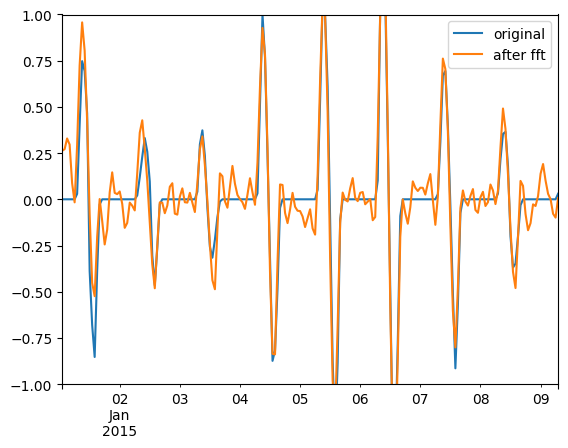

In [28]:
ts[1:200].plot()
plt.ylim(-4,4)
pd.Series(ffilt[1:200], ts.index[1:200]).plot()
plt.ylim(-1,1)
plt.legend(["original", "after fft"])

Generally, in many of the settings we investigated, FFT had problems with the zero production ("flatline") at night.
You can play around with the parameter in
`indices = PSD > X`
to obtain the comparisons in the presentation.
The FT model later in the notebook will work better, maybe by a better choice of parameters?

# Gaussian Processes

We employ Gaussian processes as a filtering / preprocessing method, not for forecasting.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from darts import TimeSeries
from darts.models import GaussianProcessFilter
from darts.utils import timeseries_generation as tg

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Datum'>

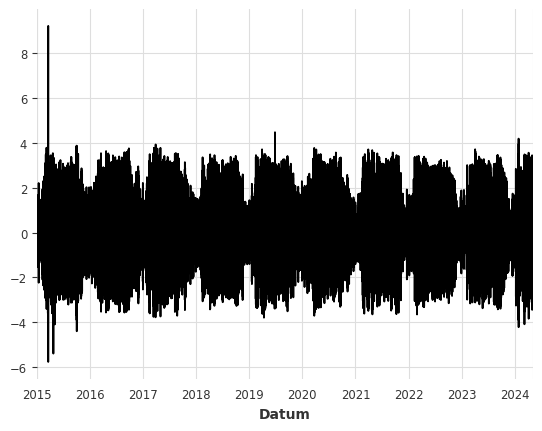

In [31]:
# The Gaussian Process will *not* work on the hourly data, but only
# on the original 15-minute data (!). Therefore, we need to have this in the meantime.
solar_ts=pd.read_csv("https://raw.githubusercontent.com/Mitmischer/solar-prediction/main/data/energy_charts.csv", sep=",", header=0)
solar_ts['Datum']=pd.to_datetime(solar_ts['Datum'], format='%Y-%m-%dT%H:%M%z', utc=True)
solar_ts=solar_ts.set_index(keys="Datum",drop=True)
# This add NaN as value for the missing indices, we can impute this later.
solar_ts = solar_ts.resample("15Min").first()
# As only a few values need imputation, so the choice of the imputation algorithm does not matter much.
solar_ts = solar_ts.interpolate(method="time")
# Only now can we infer a frequency.
solar_ts=solar_ts.asfreq(pd.infer_freq(solar_ts.index))
solar_ts_series = solar_ts.Leistung
# Normalize
train_size = int(len(solar_ts_series) * 0.9)
ts_train = solar_ts_series[:train_size]
ts_test = solar_ts_series[train_size:]
# normalize
avg, dev = ts_train.mean(), ts_train.std()
solar_ts_series = (solar_ts_series - avg)/dev
# Remove trend (TODO: compare with the approach in the Fourier series video, where they also detrend?)
solar_ts_series = solar_ts_series.diff().dropna()
# remove increasing volatility
annual_volatility = solar_ts_series.groupby(solar_ts_series.index.year).std()
annual_vol_per_day = solar_ts_series.index.map(lambda d: annual_volatility.loc[d.year])
solar_ts_series_corrected_variance = solar_ts_series/annual_vol_per_day
solar_ts_series_corrected_variance.plot()

In [32]:
from darts import TimeSeries

train_size = np.sum(solar_ts_series_corrected_variance.index < pd.Timestamp('2020-01-01 00:00:00+0000', tz='UTC'))

ts_train = solar_ts_series_corrected_variance[:train_size]
ts_test = solar_ts_series_corrected_variance[train_size:]

darts_ts_train = TimeSeries.from_series(ts_train)
darts_ts_test = TimeSeries.from_series(ts_test)

In [33]:
NOISE_DISTANCE = 0.4
SAMPLE_SIZE = 200
np.random.seed(42)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


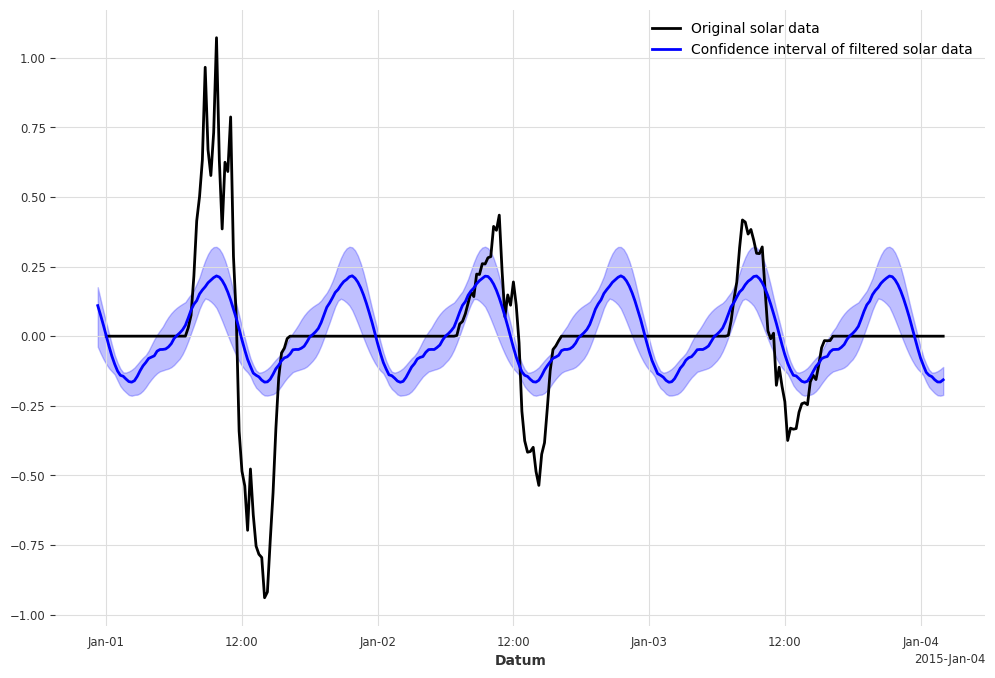

In [34]:
kernel = ExpSineSquared()

gpf = GaussianProcessFilter(
    kernel=kernel, alpha=NOISE_DISTANCE / 2, n_restarts_optimizer=100
)


filtered_x_samples = gpf.filter(darts_ts_train[:300], num_samples=10)

plt.figure(figsize=[12, 8])
darts_ts_train[:300].plot(color="black", label="Original solar data")
filtered_x_samples.plot(color="blue", label="Confidence interval of filtered solar data")
plt.legend()

Given the general energy curve shape (sinusoidal) and the increasing trend in data volatility, ExpSineSquared is the obvious first choice, but its performance is not great.
The results look similar to FFT (will be presented later in this notebook), but there is big problem - the resulting output is just repetitive (each 1-day period is identical).
We've seen this for the FFT, too, if too few frequencies were retained. Even for the very small training set, the cell takes a lot of time to execute, so the effect of raising num_samples could not be investigated further. Also, the runtimes are unbearingly slow.


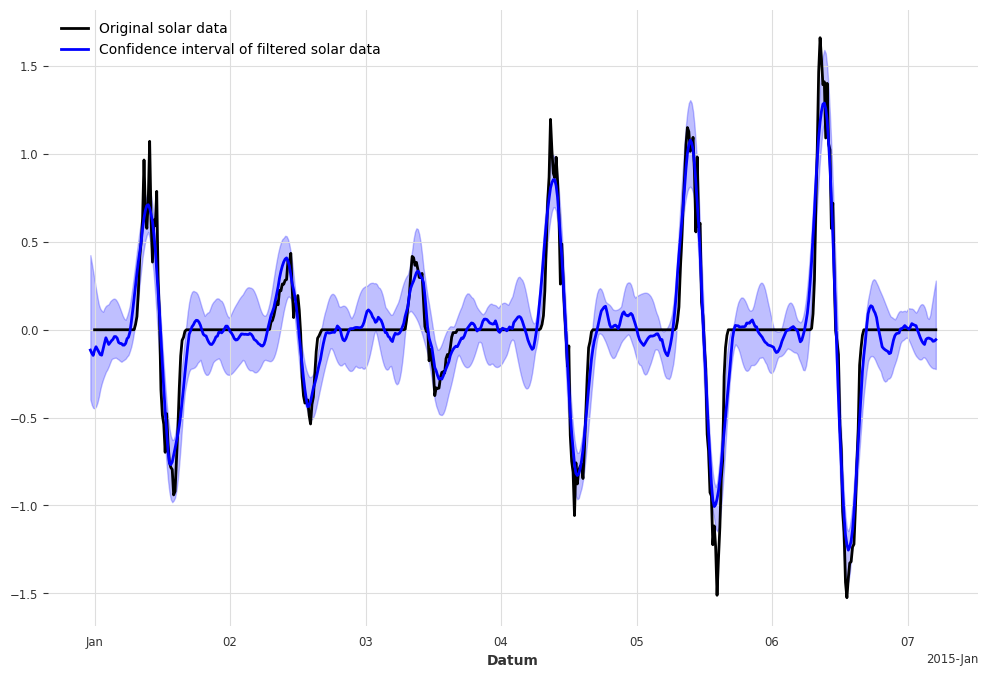

In [35]:
kernel = RBF()

gpf = GaussianProcessFilter(
    kernel=kernel, alpha=NOISE_DISTANCE / 2, n_restarts_optimizer=100
)

filtered_x_samples = gpf.filter(darts_ts_train[:600], num_samples=10) # num_samples were 100

plt.figure(figsize=[12, 8])
darts_ts_train[:600].plot(color="black", label="Original solar data")
filtered_x_samples.plot(color="blue", label="Confidence interval of filtered solar data")
plt.legend()

The RBF kernel performs much better here, capturing the general peak height. Still, as with FFT, there are problems at night time.
One can safely reduce num_samples to 50 without high increases in error, still the high execution times make applying the filter on the whole dataset unfeasible.

# Anomaly Detection



In [36]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [37]:
# Generated training sequences for use in the model:
# rolling windows of size TIME_STEPS
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


def prepare_data(x, sample_type, time_steps):
    # normalize x (=train or test data) and create windows.
    x_mean = x.mean()
    x_std = x.std()
    df_training_value = (x - x_mean) / x_std
    print(f"Number of {sample_type} samples:", len(x))

    x_ret = create_sequences(df_training_value.values, time_steps)
    print("{sample_type} input shape: ", x_ret.shape)
    return x_ret

def AE_anomaly_detection(simple, x_train, x_test, time_steps):
    x_train = prepare_data(x_train, "training", time_steps)

    if simple:
      model = keras.Sequential(
          [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
          ]
      )
    else:
      model = keras.Sequential(
          [
            layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])),
            layers.Dropout(rate=0.2),
            layers.RepeatVector(x_train.shape[1]),
            layers.LSTM(128, return_sequences=True),
            layers.Dropout(rate=0.2),
            layers.TimeDistributed(layers.Dense(x_train.shape[2])),
          ]
      )


    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
       ],
    )

    ## Get train MAE loss, compute reconstruction error threshold.
    x_train_pred = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

    plt.hist(train_mae_loss, bins=50)
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Get reconstruction loss threshold.
    # Here, we use 90% of the maximum training threshold, but one could
    # experiment with this value!
    threshold = np.max(train_mae_loss)*0.9
    print("Reconstruction error threshold: ", threshold)


    x_test = prepare_data(x_test, "test", time_steps)

    ## Get test MAE loss, determine anomalous slices.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    plt.hist(test_mae_loss, bins=50)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    # Detect all the anomalous slices.
    anomalies = test_mae_loss > threshold
    print(anomalies)
    print("Number of anomaly samples: ", np.sum(anomalies))
    return anomalies

Number of training samples: 3000
{sample_type} input shape:  (2929, 72, 1)
Epoch 1/50
21/21 [==============================] - 3s 23ms/step - loss: 0.7590 - val_loss: 0.1851
Epoch 2/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1809 - val_loss: 0.0878
Epoch 3/50
21/21 [==============================] - 0s 6ms/step - loss: 0.1134 - val_loss: 0.0561
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0913 - val_loss: 0.0452
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0782 - val_loss: 0.0383
Epoch 6/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0684 - val_loss: 0.0330
Epoch 7/50
21/21 [==============================] - 0s 8ms/step - loss: 0.0603 - val_loss: 0.0270
Epoch 8/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0536 - val_loss: 0.0232
Epoch 9/50
21/21 [==============================] - 0s 7ms/step - loss: 0.0487 - val_loss: 0.0199
Epoch 10/50
21/21 [=======================

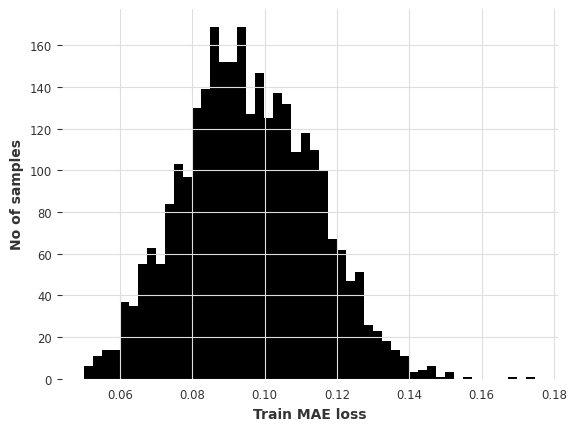

Reconstruction error threshold:  0.15729612220739697
Number of test samples: 76813
{sample_type} input shape:  (76742, 72, 1)
2399/2399 [==============================] - 6s 3ms/step


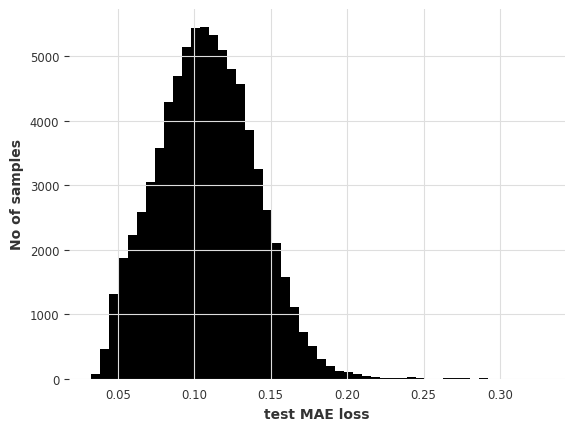

[False False False ... False False  True]
Number of anomaly samples:  4690


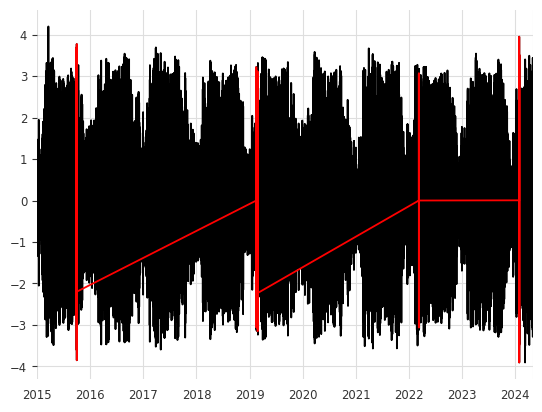

In [51]:
TIME_STEPS = 72 # window slice size
# this parameter determines the train-test split
# generally, also with just very little training data, anomaly detection looks
# reasonable.
train_end_idx=5000

test_part = ts[(train_end_idx+1):]

# Change simple to False to use an LSTM instead of a simple CNN.
anomalies = AE_anomaly_detection(True, ts.iloc[2000:train_end_idx].to_frame(),
                                 ts.iloc[(train_end_idx+1):].to_frame(),
                                 time_steps=TIME_STEPS)

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_part) - TIME_STEPS + 1):
    # get all windows where the sample is in.
    sample_anomalies = anomalies[data_idx - TIME_STEPS + 1 : data_idx]
    # a sample is anomalous if it is in more than 90% anomalous windows
    if np.mean(sample_anomalies) > 0.9:
        anomalous_data_indices.append(data_idx)
abnormal_subset = test_part.iloc[anomalous_data_indices]

fig, ax = plt.subplots()
ts.plot(legend=False, ax=ax)
if len(abnormal_subset)>0:
  abnormal_subset.plot(legend=False, ax=ax, color="r")
plt.show()

The histograms show the reconstruction errors on the training and test samples, respectively. The cutoff is set to 90% of the maximum reconstruction error on the training samples.

Note that the first 2000 time points were skipped as this yields a more regular histogram (without a heavy right tail).
In the original series (with a frequency of 15 minutes), the histogram was regular without this preprocessing.

Play around with the parameter simple to select either the CNN or the LSTM and
the parameter train_end_idx.
Only samples in the test set are evaluated for being anomalous, but we could apply the test on the training data, too.
Note that for the plots in the presentation, the time series with increasing volatility was used.

# Univariate data processing

In [52]:
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf

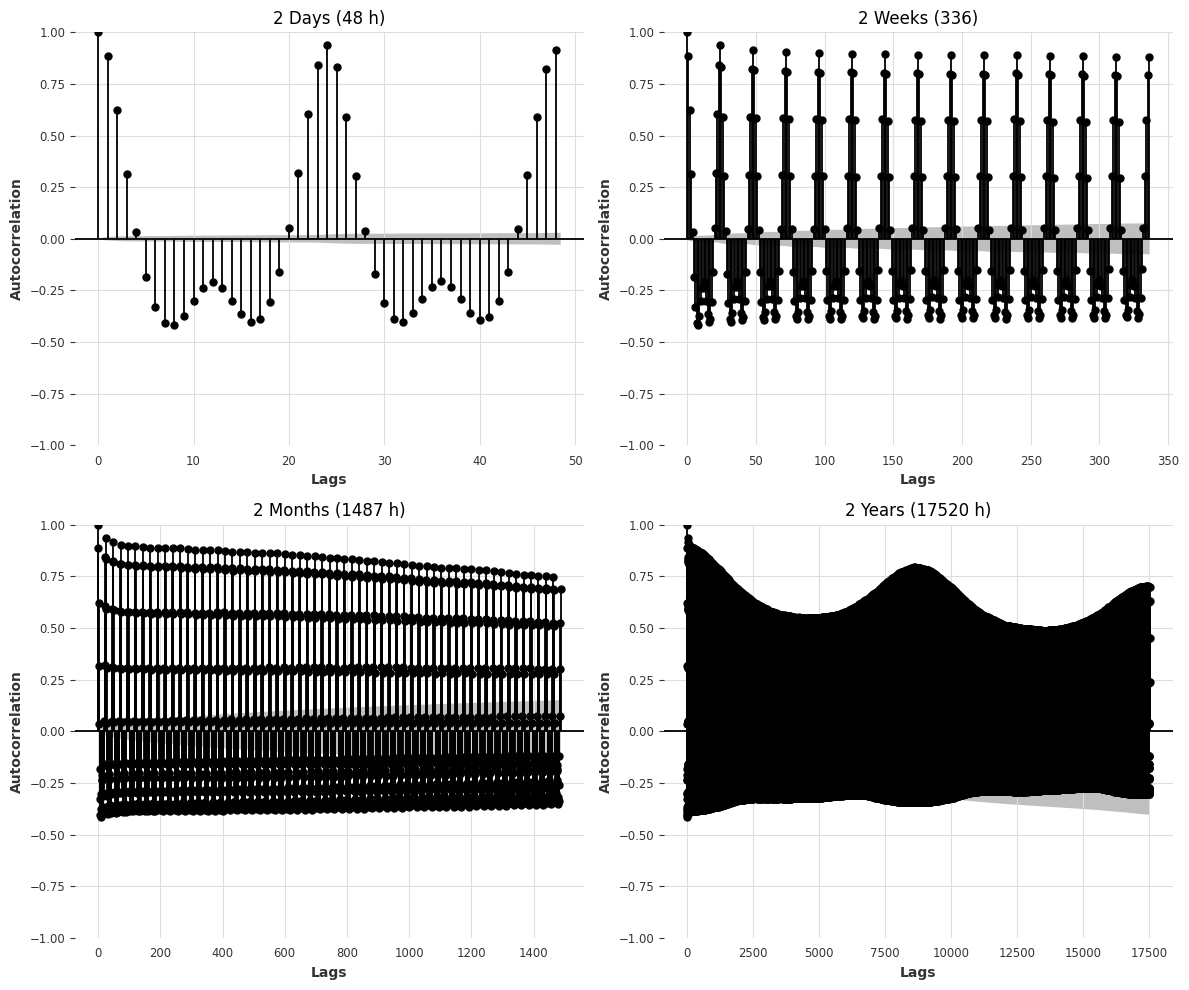

Top 5 lags with highest combined autocorrelation values:
Lag 24: 0.9366
Lag 48: 0.9159
Lag 72: 0.9045
Lag 96: 0.8987
Lag 120: 0.8957


In [53]:
# Autocorrelation plots
x_label = 'Lags'
y_label = 'Autocorrelation'

# Titles for each subplot
plot_titles = ['2 Days (48 h)', '2 Weeks (336)', '2 Months (1487 h)', '2 Years (17520 h)']
lags = [48, 336, 1487, 17520]

# X and Y labels
x_label = 'Lags'
y_label = 'Autocorrelation'

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
all_autocorr_values = {}

for i, ax in enumerate(axes.flatten()):
    tsaplots.plot_acf(ts, ax=ax, lags=lags[i])
    ax.set_title(plot_titles[i])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Compute autocorrelation values
    autocorr_values = acf(ts, nlags=lags[i])

    # Collect all autocorrelation values
    for lag in range(1, len(autocorr_values)):
        if lag not in all_autocorr_values:
            all_autocorr_values[lag] = []
        all_autocorr_values[lag].append(autocorr_values[lag])

plt.tight_layout()
plt.show()

# Combine all autocorrelation values and find the highest values
combined_autocorr_values = {lag: np.mean(values) for lag, values in all_autocorr_values.items()}

# Get the highest values
sorted_lags = sorted(combined_autocorr_values.items(), key=lambda item: item[1], reverse=True)
sorted_lags_filtered = [item for item in sorted_lags if item[0] >= 24]
top_5_combined_lags = sorted_lags_filtered[:5]
least_3_combined_lags = sorted_lags_filtered[-3:]

print("Top 5 lags with highest combined autocorrelation values:")
for lag, value in top_5_combined_lags:
    print(f"Lag {lag}: {value:.4f}")

In [54]:
# Data preparation for univariate TimeSeriesPredictionModel
lags = [24, 48, 72, 96, 120]

data = pd.DataFrame(index=ts.index)
data['Original'] = ts
for lag in lags:
    data[f'{lag}_Lag'] = ts.shift(lag)

In [55]:
# Data train-test split
train_df = data[:'2022-12-31 23:00:00+00:00']
train_df = train_df.dropna()
y_train = train_df[['Original']]
X_train = train_df.drop(columns=['Original'])

valuation_df = data['2023-01-01 00:00:00+00:00':'2023-12-31 23:00:00+00:00']
y_valuation = valuation_df[['Original']]
X_valuation = valuation_df.drop(columns=['Original'])

test_df = data['2024-01-01 00:00:00+00:00':]
y_test = test_df[['Original']]
X_test = test_df.drop(columns=['Original'])

# Univariate Models

## Naive model: Moving Average

In [56]:
from tsfcst_local_version.basic_model import TimeSeriesPredictionModel
from tsfcst_local_version.basic_model import backtesting, evaluation, random_search_optimization

ModuleNotFoundError: No module named 'tsfcst_local_version'

In [ ]:
# Moving average model
def moving_average(data: pd.DataFrame, window_size: int=3, shift_size: int=24):
    moving_avg = data.rolling(window=window_size).mean()
    shifted_moving_avg = moving_avg.shift(shift_size)
    return(shifted_moving_avg)

In [ ]:
# Plot Naive Model Predictions
naive_model = moving_average(ts)

test_date_start = '2024-01-01 00:00:00+00:00'
test_ts = ts[test_date_start:]
naive_model_print = naive_model[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(naive_model_print.index, naive_model_print, label='Moving average', linestyle='--')
plt.legend()
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Detail Plot Naive Model Predictions
naive_model = moving_average(ts)

test_date_start = '2024-04-24 00:00:00+00:00'
test_ts = ts[test_date_start:]
naive_model_print = naive_model[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(naive_model_print.index, naive_model_print, label='Moving average', linestyle='--')
plt.legend()
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Metrics Naive Model
mae, mape, mse, r2, rmse = evaluation(test_ts, naive_model_print)

print(f'Model: Naive Moving Average \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2} \n Root mean sqared error: {rmse}')

## Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
# Initializing random forest regressor as instance of TimeSeriesPredictionModel
rdnf = TimeSeriesPredictionModel(RandomForestRegressor, {'n_estimators': 150, 'criterion': 'squared_error', 'max_depth': 10})
# NaNs introduced by slicing
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

NameError: name 'TimeSeriesPredictionModel' is not defined

In [ ]:
rdnf_pred = backtesting(X_train, y_train, X_test, y_test, rdnf)
rdnf_pred = rdnf_pred.dropna()

In [ ]:
# Plot Random Forest Predictions
test_date_start = '2024-01-01 00:00+00:00'
test_ts = ts[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(rdnf_pred.index, rdnf_pred['Predictions'], label='Random Forest', linestyle='--')
plt.legend()
plt.title('Random Forest')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Detail Plot Random Forest Predictions
test_date_start = pd.to_datetime('2024-04-24 00:00+00:00')
test_date_end = pd.to_datetime('2024-04-30 23:00:00+00:00')

plt.figure(figsize=(12, 6))
plt.plot(test_ts[test_date_start:test_date_end].index, test_ts[test_date_start:test_date_end], label='Original')
plt.plot(rdnf_pred[test_date_start:test_date_end].index, rdnf_pred[test_date_start:test_date_end]['Predictions'], label='Random Forest', linestyle='--')
plt.legend()
plt.title('Random Forest')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
mae, mape, mse, r2, rmse = evaluation(rdnf_pred['Original'], rdnf_pred['Predictions'])

print(f'Model: Random Forest \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2} \n Root mean squared error: {rmse}')

In [ ]:
# Metrics comparison random forest default settings v.s. optimized hyperparameters
rdn_forest_default = [0.85, 2.54, 0.83]
rdn_forest_optimized = [mae, mse, r2]
index = ['mae', 'mse',
         'r2']
df = pd.DataFrame({'Rdn Forest': rdn_forest_default,
                   'Rdn Forest optimized': rdn_forest_optimized}, index=index)
ax = df.plot.bar(rot=0)

## CatBoost

In [59]:
from catboost import CatBoostRegressor

# Initializing CatBoost regressor as instance of TimeSeriesPredictionModel
cboost = TimeSeriesPredictionModel(CatBoostRegressor, {'iterations': 2, 'learning_rate': 0.25, 'depth': 16})

ModuleNotFoundError: No module named 'catboost'

In [60]:
cboost_pred = backtesting(X_train, y_train, X_test, y_test, cboost)
cboost_pred = cboost_pred.dropna()

NameError: name 'backtesting' is not defined

In [ ]:
# Plot CatBoost Predictions
test_date_start = pd.to_datetime('2024-01-01 00:00+00:00')
test_ts = ts[test_date_start:]

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts, label='Original')
plt.plot(cboost_pred.index, cboost_pred['Predictions'], label='CatBoost', linestyle='--')
plt.legend()
plt.title('CatBoost')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
# Detail Plot CatBoost Predictions
test_date_start = pd.to_datetime('2024-04-24 00:00+00:00')
test_date_end = pd.to_datetime('2024-04-30 23:00:00+00:00')

plt.figure(figsize=(12, 6))
plt.plot(test_ts[test_date_start:test_date_end].index, test_ts[test_date_start:test_date_end], label='Original')
plt.plot(cboost_pred[test_date_start:test_date_end].index, cboost_pred[test_date_start:test_date_end]['Predictions'], label='CatBoost', linestyle='--')
plt.legend()
plt.title('CatBoost')
plt.xlabel('Date')
plt.ylabel('Time Series')
plt.show()

In [ ]:
mae, mape, mse, r2, rmse = evaluation(cboost_pred['Original'], cboost_pred['Predictions'])

print(f'Model: CatBoost \n Mean absolute error: {mae}\n Mean absolute percentage error: {mape} \n Mean squared error: {mse} \n r2_score: {r2} \n Root mean squared error: {rmse}')

## FFT model

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Theta
from darts.metrics import mae
from darts.utils.missing_values import fill_missing_values

In [82]:
plt.figure(figsize=(19,4))

<Figure size 1900x400 with 0 Axes>

<Figure size 1900x400 with 0 Axes>

In [ ]:
scaler = Scaler()

train_size = np.sum(ts.index < pd.Timestamp('2020-01-01 00:00:00+0000', tz='UTC'))
ts_train = ts[:train_size]
ts_test = ts[train_size:]

darts_ts_train = scaler.fit_transform(TimeSeries.from_series(ts_train))
darts_ts_test = scaler.transform(TimeSeries.from_series(ts_test))
darts_ts_full = scaler.transform(TimeSeries.from_series(ts))

In [83]:
def do_fourier(model, darts_ts_train, darts_ts_test):
  model.fit(darts_ts_train)
  pred_val = model.predict(len(darts_ts_test))
  plt.figure(figsize=(24,4))
  #darts_ts_train.plot(label="train")
  darts_ts_test.plot(label="val")
  print("MAE:", mae(pred_val, darts_ts_test))
  return pred_val.plot(label="prediction")

MAE: 0.031213753434838332


<Axes: xlabel='time'>

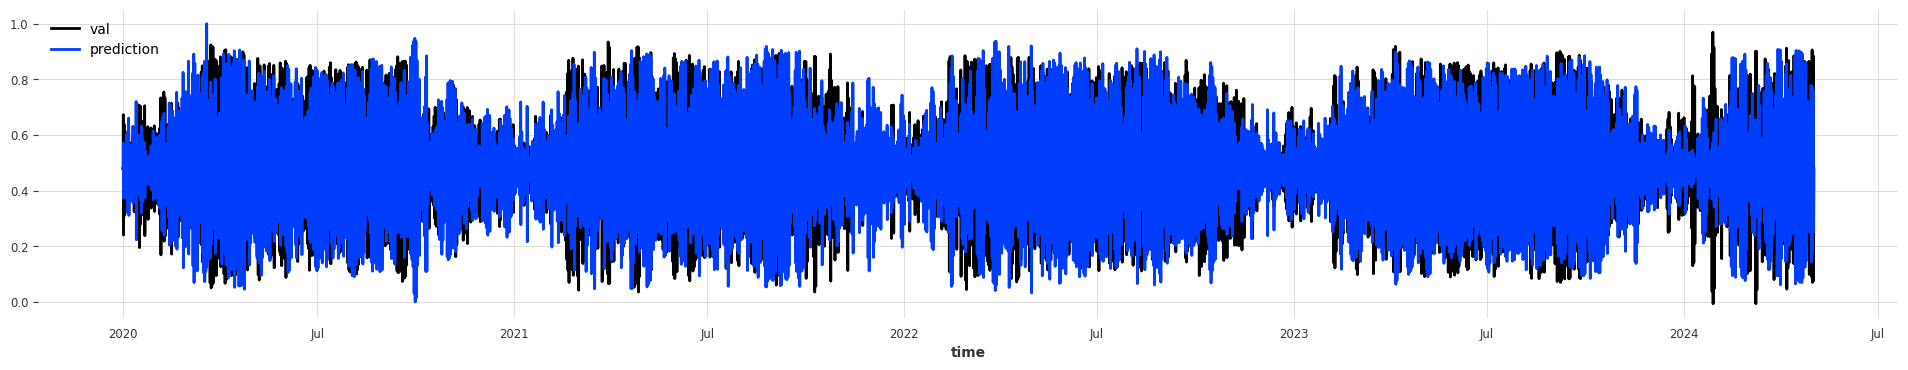

In [84]:
# baseline FFT model
# data is the same as prepared in the chapter on Gaussian Processes.
model = FFT(required_matches=set(), nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train, darts_ts_test)

MAE: 0.0748743469099193


<Axes: xlabel='time'>

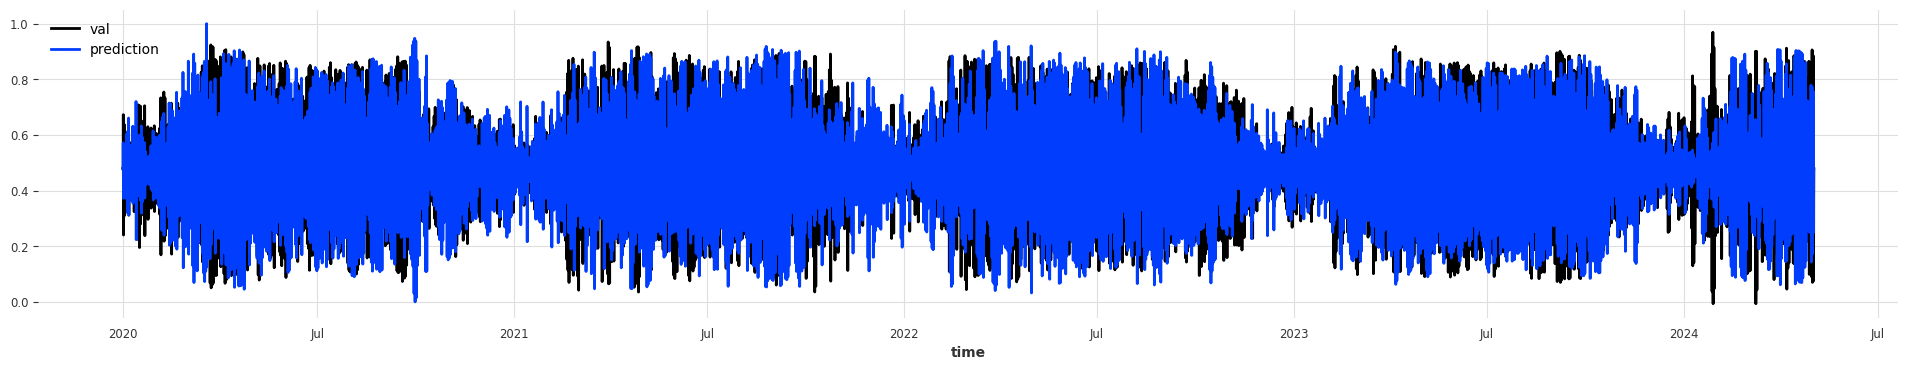

In [85]:
# interesting: matching day and month makes the result *worse* here!
model = FFT(required_matches={"day", "month"}, nr_freqs_to_keep=None)
do_fourier(model, darts_ts_train, darts_ts_test)

MAE: 0.025372267307640205


<Axes: xlabel='time'>

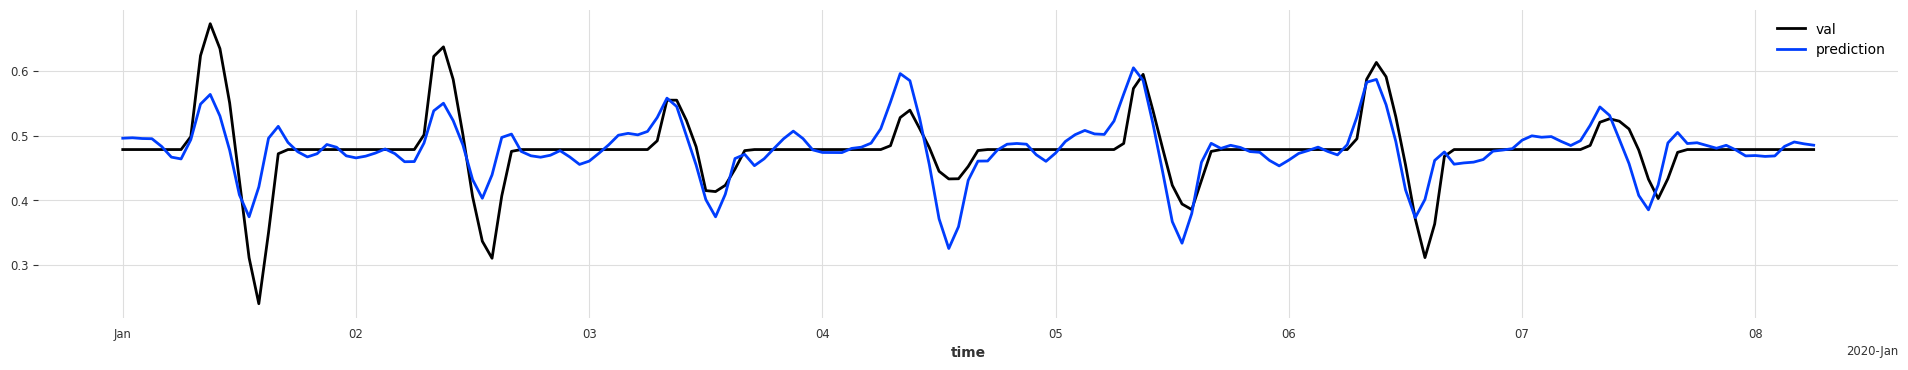

In [86]:
# zoom-in
# the plot in the presentation was done on the data on their original resolution (15 minutes)
model = FFT(nr_freqs_to_keep=5000)
do_fourier(model, darts_ts_train, darts_ts_test[:175])

In [87]:
import darts.metrics.metrics

if slow:
  model = FFT()
  print(model.gridsearch(
  parameters={
        "nr_freqs_to_keep": [10, 50, 100, 500, 1000, 2000, 5000, 10000, 15000, 20000]
    },
    series=darts_ts_train,
    val_series=darts_ts_test,
    verbose=True,
    metric = darts.metrics.metrics.mae
  ))


100%|██████████| 10/10 [00:36<00:00,  3.68s/it]

(FFT(nr_freqs_to_keep=50, required_matches=None, trend=None, trend_poly_degree=3), {'nr_freqs_to_keep': 50}, 0.043738839243655896)


Taking less frequencies can be beneficial to model performance!

## NBEATS (Darts)

In [88]:
from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset
from darts import concatenate

In [89]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "gpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

<Axes: xlabel='time'>

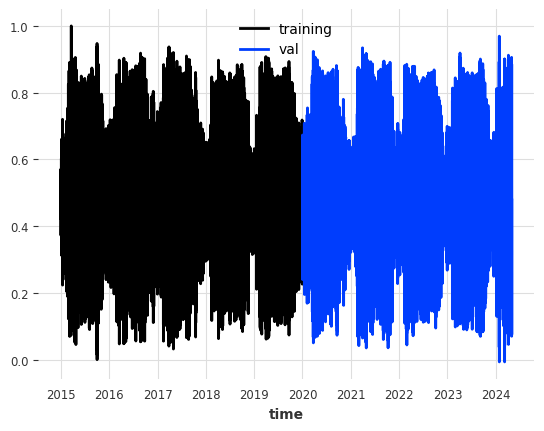

In [90]:
darts_ts_train.plot(label="training")
darts_ts_test.plot(label="val")

In [91]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [92]:
# be sure to activate gpu if you have one (three cells above this one)
if slow:
  model_nbeats.n_epochs = 100
  model_nbeats.fit(darts_ts_train, val_series=darts_ts_test)
else:
  model_nbeats.n_epochs = 20
  model_nbeats.fit(darts_ts_train[0:500], val_series=darts_ts_test[0:500])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 8.1 M  | train
-------------------------------------------------------------
8.1 M     Trainable params
2.7 K     Non-trainable params
8.1 M     Total params
32.368    Total estimated m

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [93]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


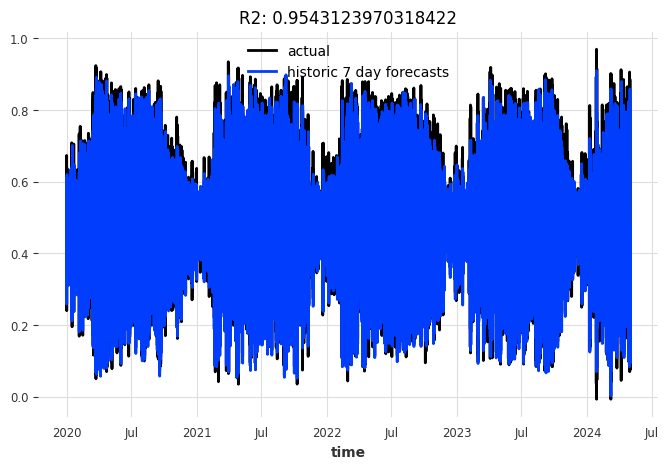

In [94]:
pred_series = model_nbeats.historical_forecasts(
    darts_ts_full,
    start=darts_ts_test.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

display_forecast(
    pred_series,
    darts_ts_full,
    "7 day",
    start_date=darts_ts_test.start_time(),
)

In [95]:
nbeats_pred = model_nbeats.predict(n=24*7)
nbeats_test = darts_ts_test[0:(24*7)]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


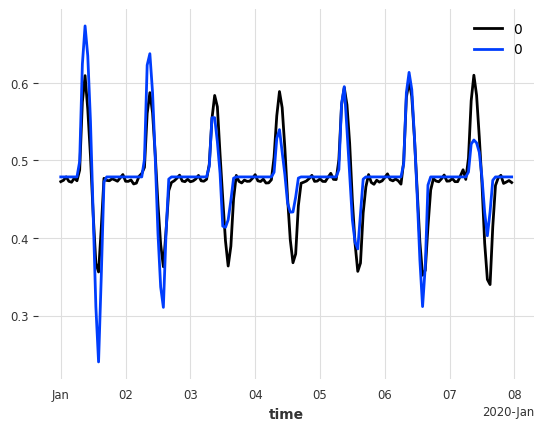

In [96]:
if slow:
  nbeats_pred.plot()
  nbeats_test.plot()
else:
  nbeats_pred.plot()
  ts_train[501:(501+24*7)].plot()

If the plot above looks very off to you, set slow to True, activate the GPU and run again!

## NHITS

In [97]:
from statsforecast import StatsForecast
from ray import tune

from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.core import NeuralForecast

from neuralforecast.losses.pytorch import DistributionLoss, MQLoss

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [98]:
ts_nhits = ts.reset_index().rename(columns={"index":"ds", 0:"y"})
# NeuralForecast is inherently multivariate. We just assign UID as our unique
# id, the exact choice doesn't matter.
ts_nhits.insert(column="unique_id", value="UID", loc=0)

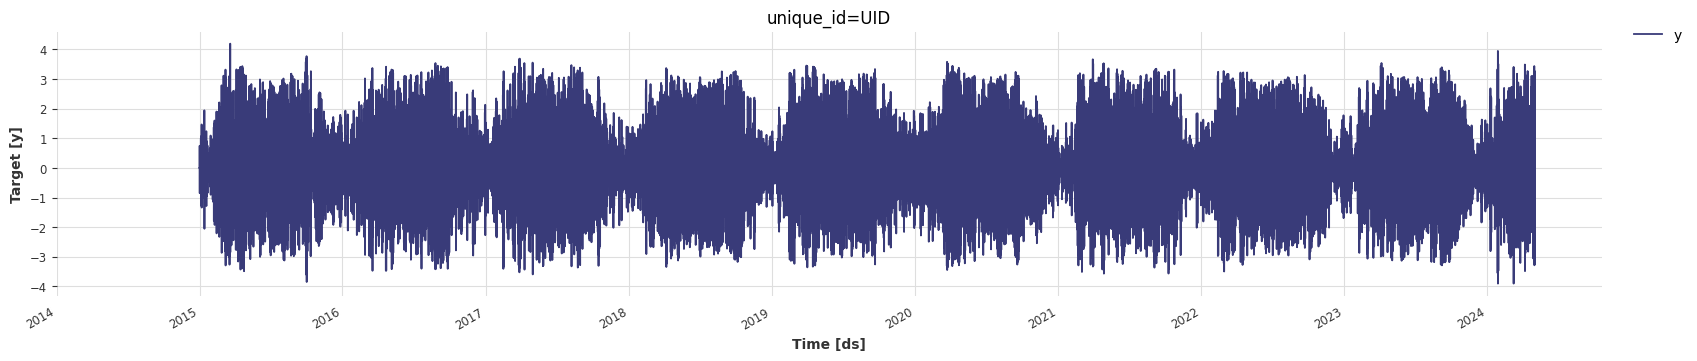

In [99]:
StatsForecast.plot(ts_nhits, engine='matplotlib')

Everything's set up!

In [167]:
horizon = 24*5 # We run into GPU-RAM limitations for larger horizons

max_steps = 1000 if slow else 50

# in the tune.choice, one can also specify multiple choices and NeuralForecase
# will optimize. That would take too long for us, though.
nhits_config = {
    "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
    "max_steps": tune.choice([max_steps]),                                         # Number of SGD steps
    "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horiz
    "batch_size": tune.choice([7]),                                           # Number of series in windows
    "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
    "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
    "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
    "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
    "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
    "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
    "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
    "random_seed": tune.randint(1, 10),
    "scaler_type": tune.choice(['robust']),
    "val_check_steps": tune.choice([100])
  }

In [168]:
models = [AutoNHITS(h=horizon,
                    loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                    config=nhits_config,
                    num_samples=5)]

nf = NeuralForecast(
    models=models,
    freq="1h"
)

In [169]:
if slow:
  nf.fit(df=ts_nhits[1:(len(ts_nhits)-5*24)])
else:
  # only test on a small subset to make sure the code is working etc.
  # NOT for production.
  nf.fit(df=ts_nhits[1:2000])

+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-07-30_22-43-05   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 5                                 |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-07-30_22-43-05
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-07-30_22-10-48_194290_213/artifacts/2024-07-30_22-43-05/_train_tune_2024-07-30_22-43-05/driver_artifacts`


(_train_tune pid=27169) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27169) Seed set to 6
(_train_tune pid=27169) GPU available: True (cuda), used: True
(_train_tune pid=27169) TPU available: False, using: 0 TPU cores
(_train_tune pid=27169) HPU available: False, using: 0 HPUs
(_train_tune pid=27169) Missing logger folder: /tmp/ray/session_2024-07-30_22-10-48_194290_213/artifacts/2024-07-30_22-43-05/_train_tune_2024-07-30_22-43-05/working_dirs/_train_tune_907e0_00000_0_activation=ReLU,batch_size=7,input_size=600,interpolation_mode=linear,learning_rate=0.0010,max_steps=100_2024-07-30_22-43-05/lightning_logs
(_train_tune pid=27169) 2024-07-30 22:43:11.503333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to regis

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 47.82it/s, v_num=0, train_loss_step=1.490, train_loss_epoch=1.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 35.25it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.010, valid_loss=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 40.68it/s, v_num=0, train_loss_step=3.010, train_loss_epoch=2.970, valid_loss=0.629]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 46.23it/s, v_num=0, train_loss_step=2.090, train_loss_epoch=2.120, valid_loss=3.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 38.29it/s, v_num=0, train_loss_step=4.120, train_loss_epoch=4.400, valid_loss=1.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=27169) 
Validation DataLoader 0: 100%|██████████| 1/1 

(_train_tune pid=27169) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=27380) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27380) Seed set to 7
(_train_tune pid=27380) GPU available: True (cuda), used: True
(_train_tune pid=27380) TPU available: False, using: 0 TPU cores
(_train_tune pid=27380) HPU available: False, using: 0 HPUs
(_train_tune pid=27380) Missing logger folder: /tmp/ray/session_2024-07-30_22-10-48_194290_213/artifacts/2024-07-30_22-43-05/_train_tune_2024-07-30_22-43-05/working_dirs/_train_tune_907e0_00001_1_activation=ReLU,batch_size=7,input_size=600,interpolation_mode=linear,learning_rate=0.0010,max_steps=100_2024-07-30_22-43-05/lightning_logs
(_train_tune pid=27380) 2024-07-30 22:43:52.598079: E external/local_xla/xla/stream_executor/cud

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 42.62it/s, v_num=0, train_loss_step=5.630, train_loss_epoch=3.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 39.97it/s, v_num=0, train_loss_step=2.740, train_loss_epoch=2.620, valid_loss=2.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 37.31it/s, v_num=0, train_loss_step=10.50, train_loss_epoch=3.790, valid_loss=2.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.32it/s]
(_train_tune pid=27380) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 39.84it/s, v_num=0, train_loss_step=3.850, train_loss_epoch=3.730, valid_loss=3.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 46.73it/s, v_num=0, train_loss_step=3.700, train_loss_epoch=3.670, valid_loss=4.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███████

(_train_tune pid=27380) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 39.46it/s, v_num=0, train_loss_step=3.740, train_loss_epoch=3.900, valid_loss=2.540]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s, v_num=0, train_loss_step=3.740, train_loss_epoch=3.740, valid_loss=3.610]


(_train_tune pid=27605) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27605) Seed set to 6
(_train_tune pid=27605) GPU available: True (cuda), used: True
(_train_tune pid=27605) TPU available: False, using: 0 TPU cores
(_train_tune pid=27605) HPU available: False, using: 0 HPUs
(_train_tune pid=27605) Missing logger folder: /tmp/ray/session_2024-07-30_22-10-48_194290_213/artifacts/2024-07-30_22-43-05/_train_tune_2024-07-30_22-43-05/working_dirs/_train_tune_907e0_00002_2_activation=ReLU,batch_size=7,input_size=600,interpolation_mode=linear,learning_rate=0.0010,max_steps=100_2024-07-30_22-43-05/lightning_logs
(_train_tune pid=27605) 2024-07-30 22:44:33.158399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to regis

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 36.99it/s, v_num=0, train_loss_step=1.330, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 47.70it/s, v_num=0, train_loss_step=1.680, train_loss_epoch=1.740, valid_loss=1.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 43.97it/s, v_num=0, train_loss_step=1.280, train_loss_epoch=1.330, valid_loss=1.660]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 38.20it/s, v_num=0, train_loss_step=1.230, train_loss_epoch=1.210, valid_loss=0.499]
(_train_tune pid=27605) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=27605) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 35.75it/s, v_num=0, train_loss_step=0.871, train_loss_epoch=0.860, valid_loss=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|███

(_train_tune pid=27605) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=27818) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=27818) Seed set to 5
(_train_tune pid=27818) GPU available: True (cuda), used: True
(_train_tune pid=27818) TPU available: False, using: 0 TPU cores
(_train_tune pid=27818) HPU available: False, using: 0 HPUs
(_train_tune pid=27818) Missing logger folder: /tmp/ray/session_2024-07-30_22-10-48_194290_213/artifacts/2024-07-30_22-43-05/_train_tune_2024-07-30_22-43-05/working_dirs/_train_tune_907e0_00003_3_activation=ReLU,batch_size=7,input_size=600,interpolation_mode=linear,learning_rate=0.0010,max_steps=100_2024-07-30_22-43-05/lightning_logs
(_train_tune pid=27818) 2024-07-30 22:45:13.114085: E external/local_xla/xla/stream_executor/cud

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 37.54it/s, v_num=0, train_loss_step=1.550, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 33.22it/s, v_num=0, train_loss_step=0.804, train_loss_epoch=0.806, valid_loss=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 45.94it/s, v_num=0, train_loss_step=0.763, train_loss_epoch=0.766, valid_loss=0.571]
(_train_tune pid=27818) 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 47.81it/s, v_num=0, train_loss_step=0.671, train_loss_epoch=0.718, valid_loss=0.337]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 41.56it/s, v_num=0, train_loss_step=0.843, train_loss_epoch=0.822, valid_loss=0.197]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 46.31it/s, v

(_train_tune pid=27818) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=28045) /usr/local/lib/python3.10/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=28045) Seed set to 2
(_train_tune pid=28045) GPU available: True (cuda), used: True
(_train_tune pid=28045) TPU available: False, using: 0 TPU cores
(_train_tune pid=28045) HPU available: False, using: 0 HPUs
(_train_tune pid=28045) Missing logger folder: /tmp/ray/session_2024-07-30_22-10-48_194290_213/artifacts/2024-07-30_22-43-05/_train_tune_2024-07-30_22-43-05/working_dirs/_train_tune_907e0_00004_4_activation=ReLU,batch_size=7,input_size=600,interpolation_mode=linear,learning_rate=0.0010,max_steps=100_2024-07-30_22-43-05/lightning_logs
(_train_tune pid=28045) 2024-07-30 22:45:53.994496: E external/local_xla/xla/stream_executor/cud

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 42.34it/s, v_num=0, train_loss_step=1.400, train_loss_epoch=1.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 44.56it/s, v_num=0, train_loss_step=3.050, train_loss_epoch=3.060, valid_loss=1.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 44.43it/s, v_num=0, train_loss_step=1.780, train_loss_epoch=1.990, valid_loss=3.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 35.66it/s, v_num=0, train_loss_step=1.430, train_loss_epoch=1.630, valid_loss=1.850]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.64it/s]
(_train_tune pid=28045) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 35.73it/s, v_num=0, train_loss_step=1.870, train_loss_epoch=1.820, valid_loss=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|       

(_train_tune pid=28045) `Trainer.fit` stopped: `max_steps=1000` reached.
2024-07-30 22:46:26,512	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-07-30_22-43-05' in 0.0179s.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s, v_num=0, train_loss_step=1.540, train_loss_epoch=1.470, valid_loss=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s, v_num=0, train_loss_step=1.540, train_loss_epoch=1.540, valid_loss=1.330]



INFO:lightning_fabric.utilities.seed:Seed set to 6


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [170]:
fcst_df = nf.predict()
# in my understanding, the AutoNHITS column will have this information already,
# so we just drop this one (differing from the tutorial).
fcst_df = fcst_df.drop("AutoNHITS-median", axis=1)

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:1447: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


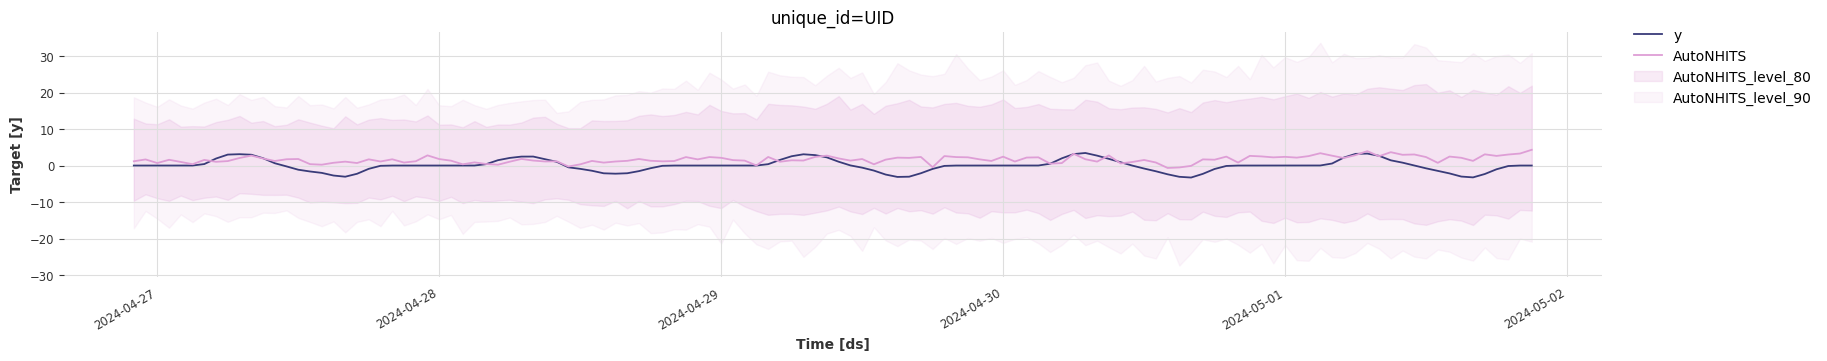

In [171]:
from IPython.display import display
%matplotlib inline
if slow:
  display(StatsForecast.plot(ts_nhits[(len(ts_nhits)-5*24):], fcst_df,engine='matplotlib', level=[80, 90]))
else:
  display(StatsForecast.plot(ts_nhits[2000-24:(2000+5*24)], fcst_df,engine='matplotlib', level=[80, 90]))


In [172]:
# as an aside, NeuralForecast also supports LSTM, so one could also do a full model comparison as follows:

if False:
  config_lstm = {
      "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
      "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
      "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
      "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
      "scaler_type": tune.choice(['robust']),                   # Scaler type
      "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
      "batch_size": tune.choice([1, 4]),                        # Number of series in batch
      "random_seed": tune.randint(1, 20),                       # Random seed
  }

  models.append(AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2))
# .. then run NeuralForecast as above.

# Example usage optimizing univariate models

In [106]:
# Model Optimization - Example usage
from sklearn.metrics import mean_squared_error

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['squared_error'],
    'max_depth': [5, 10, 20]}
    # 'iterations': [20, 25, 30],
    # 'learning_rate': [0.25, 0.5, 0.75],
    # 'depth': [5, 10, 16]}

# Example scoring function
def my_scoring_function(true, pred):
    return -mean_squared_error(true, pred)

# Perform random search optimization
best_params, best_score = random_search_optimization(
    RandomForestRegressor,
    param_grid,
    X_train= X_train,
    y_train= y_train,
    X_val = X_valuation,
    y_val= y_valuation,
    n_iter=10,
    scoring_function=my_scoring_function
)

print("Best Parameters:", best_params)
print("Best Score:", best_score)

NameError: name 'random_search_optimization' is not defined

# appendix: Extreme Values

In [ ]:
from pyextremes import __version__, get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import EVA
print("pyextremes", __version__)

In [ ]:
# "In order for the analysis results to be meaningful, data needs to be pre-processed by the user.
# This may include removal of data gaps, detrending, interpolation, removal of outliers, etc."
# ==> !! Data needs to be detrended! TODO: Does this also imply constant variance?
# I assume yes and take solar_ts_series_corrected_variance as in input
# TODO: So what exactly does pyextremes expect from the time series?
from pyextremes import EVA

model = EVA(ts)
model

In [ ]:
model.get_extremes(method="BM", block_size="365.2425D")

In [ ]:
model.fit_model()

In [ ]:
model

In [ ]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

In [ ]:
model.plot_diagnostic(alpha=0.95)

The lib can be used to obtain extreme values - either as the extreme values of a period or as all values larger than a threshold - easily.

In [ ]:
extremes = get_extremes(
    ts=solar_ts_series_corrected_variance,
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
    min_last_block=None,
)

plot_extremes(
    ts=solar_ts_series_corrected_variance,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="low",
    block_size="365.2425D",
)
extremes

In [ ]:
model.get_extremes("POT", threshold=3, r="12H")


In [ ]:
model.plot_extremes(show_clusters=True)